<a href="https://colab.research.google.com/github/josooik/DeepLearning/blob/main/segmentation_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation

![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_type.png?raw=true)


![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_model.png?raw=true)

## 데이터셋: Crowd Instance-level Human Parsing (CIHP)
---

(https://arxiv.org/abs/1811.12596)

* 38,280개의 다양한 인간 이미지
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/chip.png?raw=true)

### 1. 데이터셋 다운로드

* instance-level-human-parsing.zip(2.7G): https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

In [1]:
! gdown https://drive.google.com/u/0/uc?id=1SC_1cdjQQ-3psrthTU_l2tiCYt6K8dlB&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1SC_1cdjQQ-3psrthTU_l2tiCYt6K8dlB
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:37<00:00, 77.9MB/s]


In [2]:
! unzip -q instance-level-human-parsing.zip

### 2. 이미지 경로 설정

In [3]:
import os 
from glob import glob

# 폴더 '/content/instance-level_human_parsing/instance-level_human_parsing'
# Training
# Validation

data_dir = '/content/instance-level_human_parsing/instance-level_human_parsing'

# Training
train_img_path = glob(os.path.join(data_dir, 'Training/Images/*.jpg'))
train_mask_path = glob(os.path.join(data_dir, 'Training/Category_ids/*.png'))
print("Training_Img :", len(train_img_path))
print("Training_Mask :", len(train_mask_path))

# Training Sort
train_img_paths = sorted(train_img_path)
train_mask_paths = sorted(train_mask_path)
print("Training_Img_sort :", train_img_paths[:2])
print("Training_Mask_sort :", train_mask_paths[:2])

print("\n")

# Validation
valid_img_path = glob(os.path.join(data_dir, 'Validation/Images/*.jpg'))
valid_mask_path = glob(os.path.join(data_dir, 'Validation/Category_ids/*.png'))
print("Validation_Img :", len(valid_img_path))
print("Validation_Mask :", len(valid_mask_path))

# Validation Sort
valid_img_paths = sorted(valid_img_path)
valid_mask_paths = sorted(valid_mask_path)
print("Validation_Img_sort :", valid_img_paths[:2])
print("Validation_Mask_sort :", valid_mask_paths[:2])

Training_Img : 28280
Training_Mask : 28280
Training_Img_sort : ['/content/instance-level_human_parsing/instance-level_human_parsing/Training/Images/0000006.jpg', '/content/instance-level_human_parsing/instance-level_human_parsing/Training/Images/0000007.jpg']
Training_Mask_sort : ['/content/instance-level_human_parsing/instance-level_human_parsing/Training/Category_ids/0000006.png', '/content/instance-level_human_parsing/instance-level_human_parsing/Training/Category_ids/0000007.png']


Validation_Img : 5000
Validation_Mask : 5000
Validation_Img_sort : ['/content/instance-level_human_parsing/instance-level_human_parsing/Validation/Images/0000001.jpg', '/content/instance-level_human_parsing/instance-level_human_parsing/Validation/Images/0000003.jpg']
Validation_Mask_sort : ['/content/instance-level_human_parsing/instance-level_human_parsing/Validation/Category_ids/0000001.png', '/content/instance-level_human_parsing/instance-level_human_parsing/Validation/Category_ids/0000003.png']


## 데이터셋 제너레이터

### 함수

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# img size 128
# img = img / 255
# img = (img 127.5) - 1

class DataGenerator():
    def __init__(self, img_size, batch_size):
        self.img_size = img_size
        self.batch_size = batch_size

    def path2arr(self, path, mask=False):
        # img 일때
        if not mask:
            # path -> img
            img = load_img(path, color_mode='rgb', target_size=(self.img_size, self.img_size))
            # img -> arr
            arr = img_to_array(img, dtype='uint8')

        # mask 일때
        else:
            # path -> img
            img = load_img(path, color_mode='grayscale', target_size=(self.img_size, self.img_size))
            # img -> arr
            arr = img_to_array(img, dtype='uint8')

        return arr

    def load_datasets(self, img_paths, mask_paths):
        img_arrs = []
        mask_arrs = []

        for img_path, mask_path in zip(img_paths, mask_paths):
            img_arr = self.path2arr(img_path)
            img_arrs.append(img_arr)

            mask_arr = self.path2arr(mask_path, mask=True)
            mask_arrs.append(mask_arr)

        return np.array(img_arrs), np.array(mask_arrs)

    def preprocess(self, img_arr, mask_arr):
        img_arr = (img_arr / 127.5) - 1

        return img_arr, mask_arr

    def tf_preprocess(self, img_arr, mask_arr):
        img_arr = (tf.cast(img_arr, tf.float32) / 127.5) - 1
        mask_arr = tf.cast(mask_arr, tf.float32)  # int -> float

        return img_arr, mask_arr

    def generate(self, img_paths, mask_paths):
        # 기존 Numpy 이용한 데이터셋 처리
        img_arrs, mask_arrs = self.load_datasets(train_img_paths, train_mask_paths)
        print(img_arrs.shape, mask_arrs.shape)

        # tensorflow dataset 라이브러리 사용 여기서부터는 Numpy가 아니라 Tensor 이용
        dataset = tf.data.Dataset.from_tensor_slices((img_arrs, mask_arrs))
        dataset = dataset.map(self.tf_preprocess,
                              num_parallel_calls=tf.data.AUTOTUNE)  # 전처리, num_parallel_calls=tf.data.AUTOTUNE -> 병렬처리
        dataset = dataset.batch(self.batch_size, drop_remainder=True)  # batch 사이즈 지정
        print(dataset)

        return dataset

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

def hist_val(img_arr, mask_arr):
  plt.figure(figsize=(10,4))

  plt.subplot(1,2,1)
  img_shape = img_arr.shape[0] * img_arr.shape[1] * img_arr.shape[2]
  plt.hist(np.reshape(img_arr, img_shape)) # 1차원인풋

  plt.subplot(1,2,2)
  mask_shape = mask_arr.shape[0] * mask_arr.shape[1] * mask_arr.shape[2]
  plt.hist(np.reshape(mask_arr, mask_shape)) # 1차원인풋
  print('* # of mask categories :', set(np.reshape(mask_arr, mask_shape))) # set 중복 제거, mask의 카테고리 확인

  plt.show()

def display_img(img_arr, mask_arr, mask_cmap=None):
  plt.figure(figsize=(12,4))

  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(img_arr)

  plt.subplot(1,3,2)
  plt.axis('off')
  plt.imshow(img_arr)
  plt.imshow(mask_arr[:,:,0], alpha=0.6, cmap=mask_cmap) # cmap 기본은 None

  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(mask_arr[:,:,0], cmap=mask_cmap) # mask_arr (가로, 세로, 1) -> (가로, 세로)
  
  plt.show()

### 정의

In [6]:
IMG_SIZE = 128
BATCH_SIZE = 16
dg = DataGenerator(IMG_SIZE, BATCH_SIZE)

### 1. array 변환

In [7]:
idx = 55

img_arr = dg.path2arr(train_img_paths[idx])
mask_arr = dg.path2arr(train_mask_paths[idx], mask=True)

print(img_arr.shape, mask_arr.shape)

(128, 128, 3) (128, 128, 1)


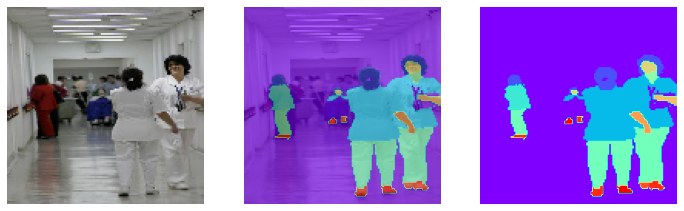

In [8]:
display_img(img_arr, mask_arr, mask_cmap='rainbow')

* # of mask categories : {0, 2, 5, 7, 9, 10, 13, 14, 15, 17, 18, 19}


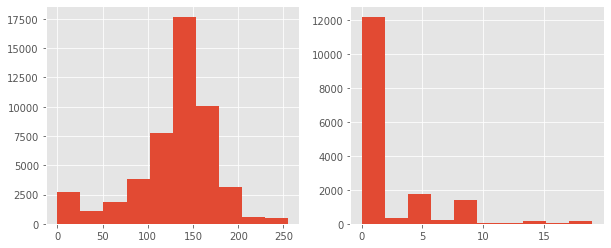

In [9]:
hist_val(img_arr, mask_arr)

### 전처리

In [10]:
img_pre, mask_pre = dg.preprocess(img_arr, mask_arr)
print(img_pre.shape, mask_pre.shape)

(128, 128, 3) (128, 128, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


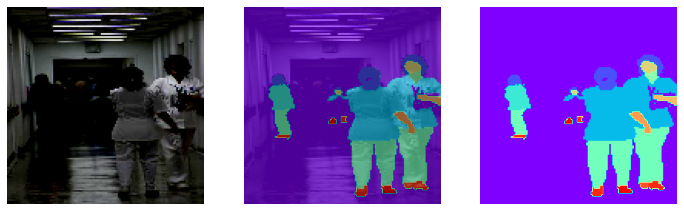

In [11]:
display_img(img_pre, mask_pre, mask_cmap='rainbow')

* # of mask categories : {0, 2, 5, 7, 9, 10, 13, 14, 15, 17, 18, 19}


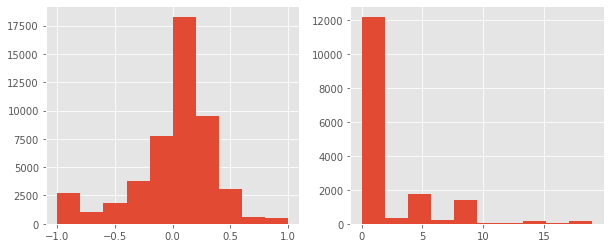

In [12]:
hist_val(img_pre, mask_pre)

### 3. 데이터셋 정의

In [13]:
train_ds = dg.generate(train_img_paths[:5000], train_mask_paths[:5000])
valid_ds = dg.generate(valid_img_paths, valid_mask_paths)

print("* Train_ds :", train_ds)
print("* Valid_ds :", valid_ds)

(28280, 128, 128, 3) (28280, 128, 128, 1)
<BatchDataset shapes: ((16, 128, 128, 3), (16, 128, 128, 1)), types: (tf.float32, tf.float32)>
(28280, 128, 128, 3) (28280, 128, 128, 1)
<BatchDataset shapes: ((16, 128, 128, 3), (16, 128, 128, 1)), types: (tf.float32, tf.float32)>
* Train_ds : <BatchDataset shapes: ((16, 128, 128, 3), (16, 128, 128, 1)), types: (tf.float32, tf.float32)>
* Valid_ds : <BatchDataset shapes: ((16, 128, 128, 3), (16, 128, 128, 1)), types: (tf.float32, tf.float32)>


## 모델: UNet
---

![]( https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/unet2.png?raw=true)

### 1. 모델 생성

In [14]:
from tensorflow.keras import layers, models, Input, utils

def get_unet(img_size, num_classes):
  inputs = Input(shape=(img_size, img_size, 3))

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x_pre = x

  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(x_pre)
    x = layers.add([x, residual])
    x_pre = x

  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(x_pre)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    x_pre = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = models.Model(inputs, outputs)
  return model

### 2. 모델 컴파일

In [15]:
NUM_CLASSES = 20
model = get_unet(IMG_SIZE, NUM_CLASSES)

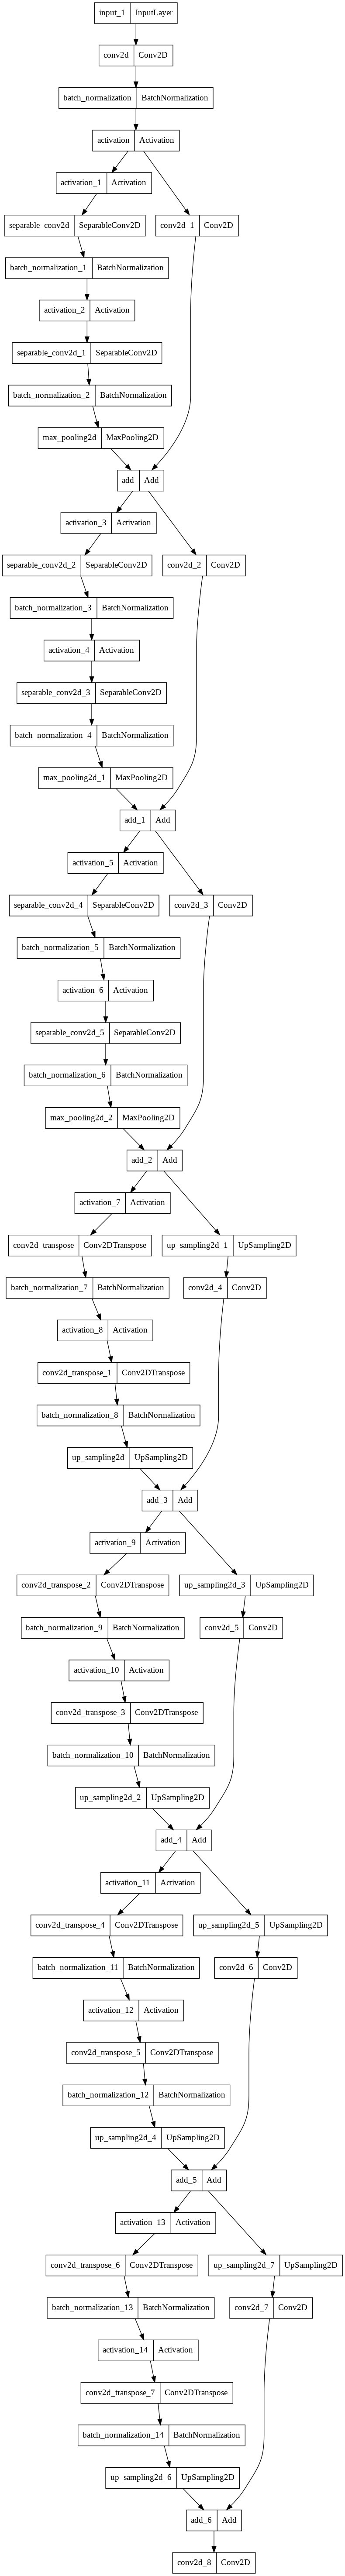

In [16]:
tf.keras.utils.plot_model(model)

In [17]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss,
              optimizer = optimizer,
              metrics = ['accuracy'])

### 3. 모델 학습

In [18]:
ckp = tf.keras.callbacks.ModelCheckpoint("unet_chip.h5", save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, # 0.2씩 lr 줄이기
                                                 patience=5) # 5번동안 loss 안줄면
history = model.fit(train_ds,
                    validation_data = valid_ds,
                    epochs=30,
                    callbacks=[ckp]) # 학습성능 향상 시키는 모듈

Epoch 1/30
1767/1767 [==============================] - ETA: 0s - loss: 1.0427 - accuracy: 0.6725

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1767/1767 [==============================] - 341s 186ms/step - loss: 1.0427 - accuracy: 0.6725 - val_loss: 0.9303 - val_accuracy: 0.7000
Epoch 2/30
1767/1767 [==============================] - 327s 185ms/step - loss: 0.8360 - accuracy: 0.7254 - val_loss: 0.8092 - val_accuracy: 0.7369
Epoch 3/30
1767/1767 [==============================] - 328s 186ms/step - loss: 0.7626 - accuracy: 0.7475 - val_loss: 0.7471 - val_accuracy: 0.7551
Epoch 4/30
1767/1767 [==============================] - 329s 186ms/step - loss: 0.7118 - accuracy: 0.7629 - val_loss: 0.7245 - val_accuracy: 0.7604
Epoch 5/30
1767/1767 [==============================] - 327s 185ms/step - loss: 0.6716 - accuracy: 0.7755 - val_loss: 0.6993 - val_accuracy: 0.7689
Epoch 6/30
1767/1767 [==============================] - 327s 185ms/step - loss: 0.6367 - accuracy: 0.7865 - val_loss: 0.6813 - val_accuracy: 0.7731
Epoch 7/30
1767/1767 [==============================] - 326s 185ms/step - loss: 0.6069 - accuracy: 0.7966 - val_loss: 0.686

### 모델 시각화

In [19]:
def plot_leraning_curve(H):
    N = len(H.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N),  H.history["loss"], label="train_loss", marker='o',)
    plt.plot(np.arange(0, N),  H.history["val_loss"], label="val_loss", marker='o')
    plt.plot(np.arange(0, N),  H.history["accuracy"], label="train_acc", marker='o')
    plt.plot(np.arange(0, N),  H.history["val_accuracy"], label="val_acc", marker='o')
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("lerning_curve")
    plt.show()

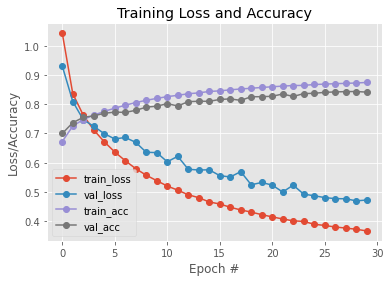

In [20]:
plot_leraning_curve((history))

### 4. 모델 평가

In [21]:
model.evaluate(valid_ds)

1767/1767 [==============================] - 91s 51ms/step - loss: 0.4724 - accuracy: 0.8414


[0.4724437892436981, 0.8413978219032288]

### 5. 추론

In [35]:
def img_predict(path, model, mask_cmap=None):

  #path = train_img_path[300]
  # path -> arr
  img_arr = dg.path2arr(path)
  print("img_arr.shape :", img_arr.shape)

  # arr -> 전처리
  img_pre, _ = dg.preprocess(img_arr, img_arr)
  print("img_pre.shape :", img_pre.shape)

  # 모델예측
  pred = model.predict(tf.expand_dims(img_pre,0))[0]
  pred = np.argmax(pred, axis=2)
  print("pred.shape :", pred.shape)

  # 디스플레이
  display_img(img_arr, np.expand_dims(pred, 2), mask_cmap='rainbow')

img_arr.shape : (128, 128, 3)
img_pre.shape : (128, 128, 3)
pred.shape : (128, 128)


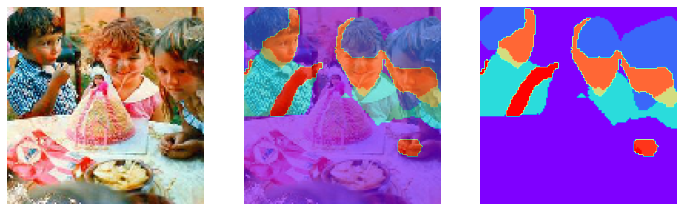

In [38]:
img_predict(train_img_paths[170], model, mask_cmap='rainbow')